### Imports

In [ ]:
import re, html, string, os, time
import pandas as pd
import numpy as np
from nltk.corpus import stopwords, wordnet as wn
import nltk; nltk.download('stopwords', quiet=True)
for pkg in ['punkt','averaged_perceptron_tagger_eng','wordnet','omw-1.4','stopwords']:
    nltk.download(pkg, quiet=True)

from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from collections import Counter

### Data

In [120]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

In [121]:
train_df['all_text_raw'] = (train_df['title'].fillna('') + ' ' + train_df['text'].fillna('')).str.strip()
val_df['all_text_raw'] = (val_df['title'].fillna('') + ' ' + val_df['text'].fillna('')).str.strip()

### Data Preprocess

In [122]:
URL_RE = re.compile(r'http[s]?://\S+|www\.\S+')
HTML_TAG_RE = re.compile(r'<[^>]+>')
PUNCT_TABLE = str.maketrans('', '', string.punctuation)

stop_en = set(stopwords.words('english'))
negations = {"no","nor","not","don't","didn't","isn't","aren't","won't","can't","couldn't","shouldn't","wasn't","weren't","haven't","hasn't","hadn't","never","none","nobody","nothing","nowhere","neither"}
stop_en = {w for w in stop_en if w not in negations}

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag: str):
    if tag.startswith('J'): return wn.ADJ
    if tag.startswith('V'): return wn.VERB
    if tag.startswith('N'): return wn.NOUN
    if tag.startswith('R'): return wn.ADV
    return wn.NOUN

def lemma_clean(s: str) -> str:
    if not isinstance(s, str): return ""
    s = html.unescape(s)
    s = re.sub(HTML_TAG_RE, ' ', s)
    s = re.sub(URL_RE, ' ', s)
    s = re.sub(r'\S+@\S+', ' ', s)
    s = re.sub(r'[@#]\w+', ' ', s)
    s = re.sub(r'\d+', ' ', s)
    s = s.translate(PUNCT_TABLE)

    tokens = [t for t in word_tokenize(s) if len(t) > 2]
    tokens = [t for t in tokens if t not in stop_en]
    tagged = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(tok, pos=penn_to_wn(tag)) for tok, tag in tagged]
    return ' '.join(lemmas)


In [123]:
train_df['clean_text'] = train_df['all_text_raw'].apply(lemma_clean)
train_df = train_df[train_df['clean_text'].str.len() > 0].reset_index(drop=True)

val_df['clean_text'] = val_df['all_text_raw'].apply(lemma_clean)
val_df = val_df[val_df['clean_text'].str.len() > 0].reset_index(drop=True)

In [124]:
X = train_df['clean_text'].values
y = train_df['type'].values
X_val = val_df['clean_text'].values
y_val = val_df['type'].values

### Pipeline

In [125]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=3,
        max_features=50000,
        sublinear_tf=True,
        stop_words='english',
        lowercase=False
    )),
    ('clf', LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=2000
    ))
])

### Fitting

In [126]:
pipe.fit(X, y)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False
,preprocessor,None
,tokenizer,None


In [127]:
y_pred = pipe.predict(X_val)

### Metrics

In [128]:
y_scores = pipe.decision_function(X_val)
acc   = accuracy_score(y_val, y_pred)
prec  = precision_score(y_val, y_pred, pos_label='true', zero_division=0)
rec   = recall_score(y_val, y_pred,    pos_label='true', zero_division=0)
f1_ma = f1_score(y_val, y_pred, average='macro', zero_division=0)
f1_mi = f1_score(y_val, y_pred, average='micro', zero_division=0)
metrics = {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1_macro':f1_ma, 'f1_micro':f1_mi}

### Visualization

In [129]:
df = train_df.copy()


texts_all  = df['clean_text'].astype(str)
texts_fake = df.loc[df['type']=='fake','clean_text'].astype(str)
texts_true = df.loc[df['type']=='true','clean_text'].astype(str)

def toks(series):
    out = []
    for s in series:
        out.extend([t for t in s.split() if len(t) >= 3])
    return out

freq_all  = Counter(toks(texts_all))
freq_fake = Counter(toks(texts_fake))
freq_true = Counter(toks(texts_true))

#### Save into folder


In [130]:
outdir = "figures"
os.makedirs(outdir, exist_ok=True)
ts = time.strftime("%Y%m%d-%H%M%S")
def savefig(name):
    path = os.path.join(outdir, f"{name}_{ts}.png")
    plt.savefig(path, dpi=200, bbox_inches='tight')
    print("Saved ->", path)

#### Wordcloud

Saved -> figures/wordcloud_all_20251020-094459.png


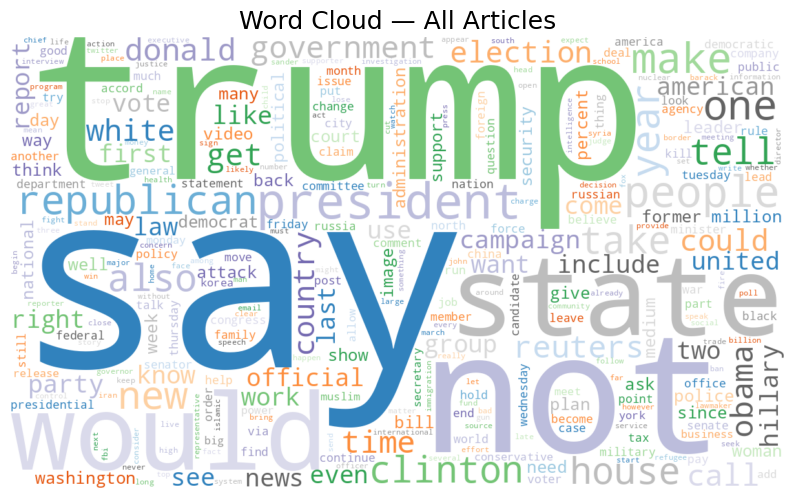

In [131]:
try:
    from wordcloud import WordCloud
    def wc_from(counter, title, fname):
        wc = WordCloud(width=1200, height=700, background_color="white",
                       prefer_horizontal=0.9, colormap="tab20c", max_words=300
                      ).generate_from_frequencies(counter)
        plt.figure(figsize=(10,6))
        plt.imshow(wc, interpolation="bilinear"); plt.axis("off")
        plt.title(title, fontsize=18)
        savefig(fname); plt.show()

    wc_from(freq_all,  "Word Cloud — All Articles", "wordcloud_all")
except Exception as e:
    print("Note: install 'wordcloud' to enable word clouds. Skipping word clouds.", e)


#### Pie diagram

Saved -> figures/class_distribution_pie_20251020-094459.png


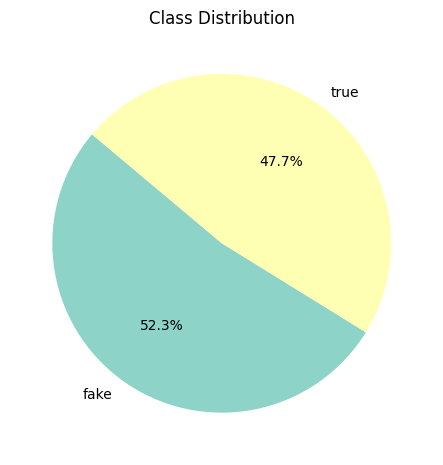

In [132]:
counts = df['type'].value_counts().reindex(['fake','true']).fillna(0)
plt.figure(figsize=(5.5,5.5))
plt.pie(counts.values, labels=['fake','true'], autopct='%1.1f%%',
        startangle=140, colors=plt.cm.Set3.colors)
plt.title("Class Distribution")
savefig("class_distribution_pie"); plt.show()

#### Top Words

Saved -> figures/top_words_all_20251020-094459.png


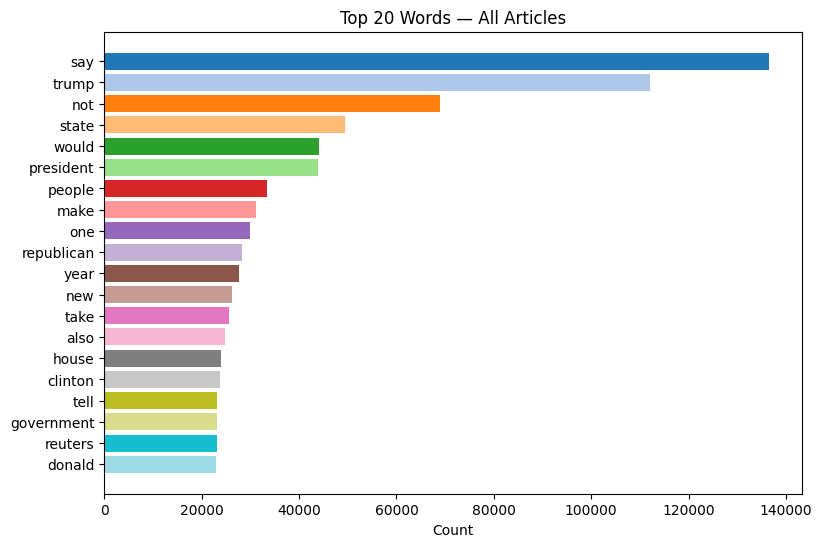

In [133]:
def plot_top(counter, title, fname, topn=20):
    items = counter.most_common(topn)
    if not items: 
        print("No items:", title); 
        return
    terms, counts = zip(*items)
    idx = np.arange(len(terms))
    colors = plt.cm.tab20(idx / max(1, len(terms)-1))
    plt.figure(figsize=(9,6))
    plt.barh(idx, counts, color=colors)
    plt.yticks(idx, terms); plt.gca().invert_yaxis()
    plt.xlabel("Count"); plt.title(title)
    savefig(fname); plt.show()

plot_top(freq_all,  "Top 20 Words — All Articles", "top_words_all")

#### RMSE

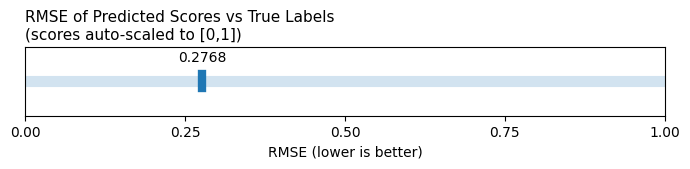

In [134]:
scores = np.asarray(y_scores, dtype=float)
scaled = False
if scores.min() < 0 or scores.max() > 1:
    smin, smax = scores.min(), scores.max()
    scores = (scores - smin) / (smax - smin + 1e-12)
    scaled = True

yt = pd.Series(y_val).astype(str).str.strip().str.lower()
y_true01 = (yt == 'true').astype(int).to_numpy(dtype=float)
rmse = float(np.sqrt(np.mean((scores - y_true01) ** 2)))

fig, ax = plt.subplots(figsize=(7, 1.8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.plot([0, 1], [0.5, 0.5], linewidth=8, alpha=0.2)
ax.axvline(rmse, ymin=0.4, ymax=0.6, linewidth=6)
ax.text(rmse, 0.75, f"{rmse:.4f}", ha='center', va='bottom', fontsize=10)

ax.set_yticks([])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel("RMSE (lower is better)")
title = "RMSE of Predicted Scores vs True Labels"
subtitle = "(scores auto-scaled to [0,1])" if scaled else "(probabilities)"
ax.set_title(f"{title}\n{subtitle}", loc='left', fontsize=11)

plt.tight_layout()

#### Confusion matrix

Saved -> figures/confusion_matrix_20251020-094459.png


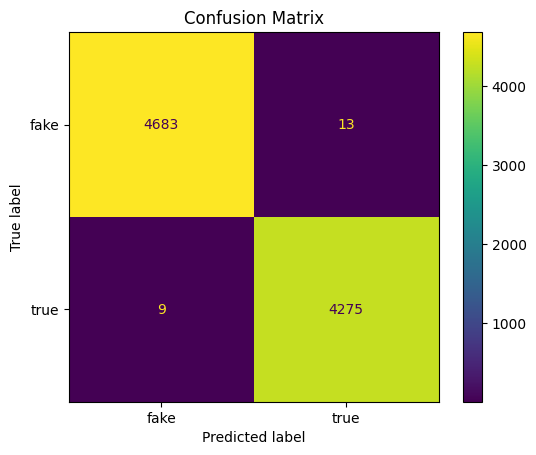

In [135]:
cm = confusion_matrix(y_val, y_pred, labels=['fake','true'])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake','true']).plot(values_format='d')
plt.title("Confusion Matrix")
savefig("confusion_matrix"); plt.show()